In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pyswarms as ps

# Load the dataset
df = pd.read_csv('AIDS_Classification.csv')
# Handle missing values - fill with median for numerical, mode for categorical
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

# Feature Engineering
df['cd4_cd8_ratio'] = df['cd40'] / df['cd80']
df['cd4_change'] = df['cd420'] - df['cd40']
df['cd8_change'] = df['cd820'] - df['cd80']

# Drop unnecessary columns
df.drop(['time', 'str2', 'strat'], axis=1, errors='ignore', inplace=True)
# Convert categorical variables to dummy variables
cat_cols = ['trt', 'gender', 'race', 'homo', 'drugs', 'oprior', 'z30', 'symptom', 'treat', 'offtrt']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Split data into features and target
X = df.drop('infected', axis=1)
y = df['infected']
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
num_cols = ['age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820', 'cd4_cd8_ratio', 'cd4_change', 'cd8_change']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Baseline Model (without feature selection)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred)

# Define fitness function for PSO using cross-validation
def fitness_function(feature_selection):
    selected_indices = np.where(feature_selection > 0.5)[0]
    if len(selected_indices) == 0:
        return 1 - baseline_accuracy
    
    X_selected = X.iloc[:, selected_indices]
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Use 5-fold cross-validation
    scores = cross_val_score(model, X_selected, y, cv=5, scoring='accuracy')
    return 1 - np.mean(scores)  # Minimize (1 - accuracy)

# PSO Optimization with improved parameters
options = {'c1': 1.5, 'c2': 2.0, 'w': 0.7, 'k': 5, 'p': 2}
optimizer = ps.discrete.BinaryPSO(n_particles=20, dimensions=X.shape[1], options=options)
best_cost, best_pos = optimizer.optimize(fitness_function, iters=50)

# Select best features from PSO
selected_indices_pso = np.where(best_pos > 0.5)[0]
X_train_pso = X_train.iloc[:, selected_indices_pso]
X_test_pso = X_test.iloc[:, selected_indices_pso]

# Train model with PSO-selected features
rf_pso = RandomForestClassifier(n_estimators=200, random_state=42)
rf_pso.fit(X_train_pso, y_train)
y_pred_pso = rf_pso.predict(X_test_pso)
pso_accuracy = accuracy_score(y_test, y_pred_pso)

# Print results
print("Selected Features:", list(X.columns[selected_indices_pso]))
print("Baseline Accuracy:", baseline_accuracy)
print("PSO Feature Selection Accuracy:", pso_accuracy)

# Display Classification Report and Confusion Matrix
def display_results(y_true, y_pred):
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

display_results(y_test, y_pred)
display_results(y_test, y_pred_pso)

# Display if AIDS is detected or not
def detect_aids(predictions):
    return "Yes, AIDS is detected" if any(predictions) else "No, AIDS is not detected"

aids_detection_baseline = detect_aids(y_pred)
aids_detection_pso = detect_aids(y_pred_pso)

print("AIDS Detection (Baseline):", aids_detection_baseline)
print("AIDS Detection (PSO):", aids_detection_pso)


2025-04-02 10:22:41,580 - pyswarms.discrete.binary - INFO - Optimize for 50 iters with {'c1': 1.5, 'c2': 2.0, 'w': 0.7, 'k': 5, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|50/50, best_cost=0.224
2025-04-02 10:27:08,408 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.22394558865372416, best pos: [1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0]


Selected Features: ['age', 'hemo', 'preanti', 'cd420', 'cd820', 'cd4_cd8_ratio', 'cd4_change', 'cd8_change', 'trt_1', 'trt_2', 'trt_3', 'gender_1', 'race_1', 'z30_1', 'symptom_1']
Baseline Accuracy: 0.778816199376947
PSO Feature Selection Accuracy: 0.7819314641744548
Confusion Matrix:
[[459  27]
 [115  41]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.87       486
           1       0.60      0.26      0.37       156

    accuracy                           0.78       642
   macro avg       0.70      0.60      0.62       642
weighted avg       0.75      0.78      0.74       642

Confusion Matrix:
[[460  26]
 [114  42]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       486
           1       0.62      0.27      0.38       156

    accuracy                           0.78       642
   macro avg       0.71      0.61      0.62       642
weigh

2025-04-09 11:40:25,805 - pyswarms.discrete.binary - INFO - Optimize for 50 iters with {'c1': 1.5, 'c2': 2.0, 'w': 0.7, 'k': 5, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|50/50, best_cost=0.722
2025-04-09 11:45:06,816 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.7216483516483516, best pos: [1 1 1 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1]



Baseline Model Results
Confusion Matrix:
[[463  23]
 [122  34]]
Classification Report (Weighted Avg):
              precision    recall  f1-score   support

           0     0.7915    0.9527    0.8646       486
           1     0.5965    0.2179    0.3192       156

    accuracy                         0.7741       642
   macro avg     0.6940    0.5853    0.5919       642
weighted avg     0.7441    0.7741    0.7321       642


PSO Model Results
Confusion Matrix:
[[479   7]
 [143  13]]
Classification Report (Weighted Avg):
              precision    recall  f1-score   support

           0     0.7701    0.9856    0.8646       486
           1     0.6500    0.0833    0.1477       156

    accuracy                         0.7664       642
   macro avg     0.7100    0.5345    0.5062       642
weighted avg     0.7409    0.7664    0.6904       642


PSO Model with Threshold Adjustment
Confusion Matrix:
[[455  31]
 [123  33]]
Classification Report (Weighted Avg):
              precision    re

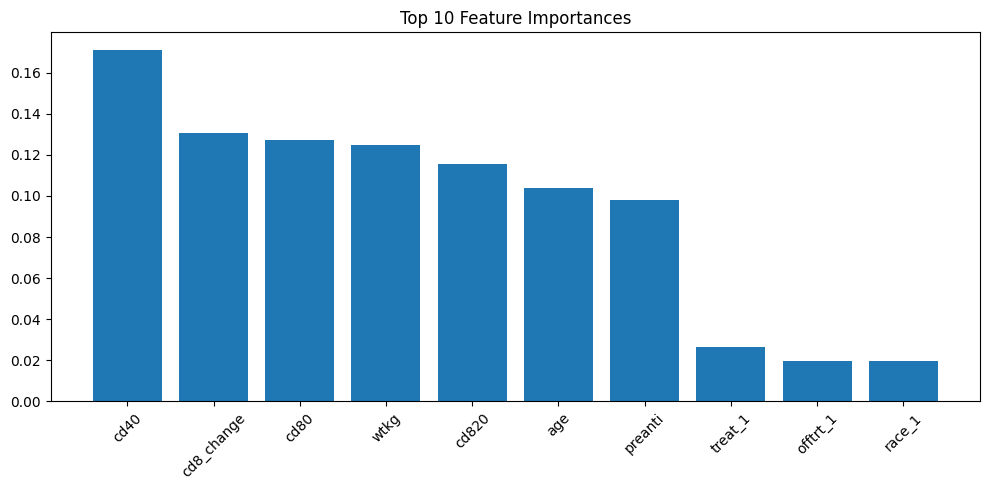

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, recall_score
import pyswarms as ps
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('AIDS_Classification.csv')

# Handle missing values - fill with median for numerical, mode for categorical
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

# Feature Engineering
df['cd4_cd8_ratio'] = df['cd40'] / df['cd80']
df['cd4_change'] = df['cd420'] - df['cd40']
df['cd8_change'] = df['cd820'] - df['cd80']

# Drop unnecessary columns
df.drop(['time', 'str2', 'strat'], axis=1, errors='ignore', inplace=True)

# Convert categorical variables to dummy variables
cat_cols = ['trt', 'gender', 'race', 'homo', 'drugs', 'oprior', 'z30', 'symptom', 'treat', 'offtrt']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Split data into features and target
X = df.drop('infected', axis=1)
y = df['infected']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
num_cols = ['age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820', 'cd4_cd8_ratio', 'cd4_change', 'cd8_change']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Baseline Model (without feature selection)
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred)

# Define fitness function for PSO using Stratified K-Fold (focus on recall)
def fitness_function(feature_selection):
    selected_indices = np.where(feature_selection > 0.5)[0]
    if len(selected_indices) == 0:
        return 1 - baseline_accuracy

    X_selected = X.iloc[:, selected_indices]
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    
    skf = StratifiedKFold(n_splits=5)
    scores = []
    for train_idx, test_idx in skf.split(X_selected, y):
        model.fit(X_selected.iloc[train_idx], y.iloc[train_idx])
        preds = model.predict(X_selected.iloc[test_idx])
        scores.append(recall_score(y.iloc[test_idx], preds))

    return 1 - np.mean(scores)

# PSO Optimization
options = {'c1': 1.5, 'c2': 2.0, 'w': 0.7, 'k': 5, 'p': 2}
optimizer = ps.discrete.BinaryPSO(n_particles=20, dimensions=X.shape[1], options=options)
best_cost, best_pos = optimizer.optimize(fitness_function, iters=50)

# Select best features from PSO
selected_indices_pso = np.where(best_pos > 0.5)[0]
X_train_pso = X_train.iloc[:, selected_indices_pso]
X_test_pso = X_test.iloc[:, selected_indices_pso]

# Train model with PSO-selected features
rf_pso = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_pso.fit(X_train_pso, y_train)
y_pred_pso = rf_pso.predict(X_test_pso)
pso_accuracy = accuracy_score(y_test, y_pred_pso)

# Adjust threshold to improve recall
y_probs = rf_pso.predict_proba(X_test_pso)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
best_threshold = 0.4  # Try different values if needed
y_pred_pso_thresh = (y_probs > best_threshold).astype(int)

# Display Classification Report and Confusion Matrix
def display_results(y_true, y_pred, title):
    print(f"\n{title}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Classification Report (Weighted Avg):")
    print(classification_report(y_true, y_pred, zero_division=0, digits=4))

display_results(y_test, y_pred, "Baseline Model Results")
display_results(y_test, y_pred_pso, "PSO Model Results")
display_results(y_test, y_pred_pso_thresh, "PSO Model with Threshold Adjustment")

# AIDS Detection Output
def detect_aids(predictions):
    return "Yes, AIDS is detected" if any(predictions) else "No, AIDS is not detected"

print("\nSelected Features:", list(X.columns[selected_indices_pso]))
print("Baseline Accuracy:", baseline_accuracy)
print("PSO Feature Selection Accuracy:", pso_accuracy)
print("AIDS Detection (Baseline):", detect_aids(y_pred))
print("AIDS Detection (PSO):", detect_aids(y_pred_pso))
print("AIDS Detection (PSO with Threshold):", detect_aids(y_pred_pso_thresh))

# Feature Importance Plot
importances = rf_pso.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = [X_train_pso.columns[i] for i in indices[:10]]

plt.figure(figsize=(10, 5))
plt.title("Top 10 Feature Importances")
plt.bar(range(10), importances[indices[:10]], align='center')
plt.xticks(range(10), top_features, rotation=45)
plt.tight_layout()
plt.show()
